### Introduction

working with data from a portuguese banking institution. The goal is to predict if the client will subscribe a term deposit, which'll be our y-variable for prediction. 

link to the dataset on Kaggle: https://www.kaggle.com/datasets/henriqueyamahata/bank-marketing/data

In [23]:
import numpy as np
import pandas as pd

In [24]:
excel_df = pd.read_csv(r"C:\Users\artix\Desktop\Workspace\pytorchproject\Datasets\bank-additional-full.csv", delimiter = ";")

10,000+ rows have data where some columns have missing values/unknowns, which is about 25% of data, but imputation isn't exactly possible because a lot of it is categorical data and mode imputation might not be the best decision because there's only two categories and might lead to higher inaccuracies.

In [25]:
columns_to_check = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y'] #removing rows with unknowns only on string columns
excel_df = excel_df[~excel_df[columns_to_check].apply(lambda row: row.str.contains('unknown', case=False, na=False)).any(axis=1)]
excel_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


with the cleaned data, the idea is now to use different models to predict y. Models I plan to use:
1) Logistic Regression with Elastic Net Regularization
2) Random Forest Classification
3) Gradient Boosting - either XGBoost, LightGBM or CatBoost
4) Support Vector Machines
5) MLP/ANN
6) RNN

In [28]:
# Logistic Regression with Elastic Net Regularization
# Attempted using pytorch instead of SKLearn

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np

X = excel_df.drop(columns=['y']) #Dropping all columns except for y
y = excel_df['y'] 

#Aliasing label encoder
le = LabelEncoder()

categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
#Performing label encoding on the categorical variables
for column in categorical_columns:
    X[column] = le.fit_transform(X[column])

#Label encoding the target variable separately
y = le.fit_transform(y)

#Train-test split, 80 - 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Performing standardization using StandardScaler for faster gradient descent
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

#Elastic Net loss function
def elastic_net_loss(output, target, model, l1_lambda, l2_lambda):
    
    bce_loss = nn.BCELoss()(output, target)
    l1_norm = sum(p.abs().sum() for p in model.parameters()) #L1 regularization(sum of absolute weights)
    l2_norm = sum(p.pow(2).sum() for p in model.parameters()) #L2 regularization(sum of squared weights)
    return bce_loss + l1_lambda * l1_norm + l2_lambda * l2_norm #Combine cross-entropy loss with L1 and L2 regularization

#Convert NumPy arrays to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

input_dim = X_train_tensor.shape[1]
model = LogisticRegressionModel(input_dim)

#Setting Hyperparameters
learning_rate = 0.01
l1_lambda = 0.001  #L1 regularization weight
l2_lambda = 0.001  #L2 regularization weight
epochs = 100

#Setting Optimizer as Stochastic Gradient Descent(SGD)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

#Training loop
for epoch in range(epochs):
    model.train()
    output = model(X_train_tensor)
    loss = elastic_net_loss(output, y_train_tensor, model, l1_lambda, l2_lambda) #Compute ElasticNet loss (cross-entropy + L1 + L2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}') #Printing loss every 10 epochs too see progress

#Evaluation
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_pred = model(X_test_tensor)
    y_pred_class = (y_pred > 0.5).float()
    accuracy = (y_pred_class == torch.tensor(y_test, dtype=torch.float32).view(-1, 1)).float().mean()
    print(f'Test Accuracy: {accuracy.item():.4f}')


#y_pred_labels = le.inverse_transform(y_pred_class.cpu().numpy().ravel().astype(int)) #converting labels back to original values
#print("Sample predictions:", y_pred_labels[:10])

Epoch [10/100], Loss: 0.7254
Epoch [20/100], Loss: 0.6987
Epoch [30/100], Loss: 0.6746
Epoch [40/100], Loss: 0.6527
Epoch [50/100], Loss: 0.6329
Epoch [60/100], Loss: 0.6149
Epoch [70/100], Loss: 0.5984
Epoch [80/100], Loss: 0.5832
Epoch [90/100], Loss: 0.5692
Epoch [100/100], Loss: 0.5562
Test Accuracy: 0.8122


#80% accuracy with Logistic Regression with Elastic Net regularization recorded.

In [21]:
# Random Forest Classification

import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix


X = excel_df.drop(columns=['y']) #Dropping all columns except for y
y = excel_df['y'] 

categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
#Performing label encoding on the categorical variables
for column in categorical_columns:
    X[column] = le.fit_transform(X[column])

#Label encoding the target variable separately
y = le.fit_transform(y)

#Train-test split, 80 - 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, max_depth = 5, random_state=1)
model.fit(X_train,y_train)
predictions = model.predict(X_test)

#calculating accuracy and metrics
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

#also calculating feature importance for an in-depth understanding of data
feature_importance = model.feature_importances_
for feature, importance in zip(X.columns, feature_importance):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Accuracy: 0.8900
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      5304
           1       0.77      0.22      0.34       794

    accuracy                           0.89      6098
   macro avg       0.83      0.60      0.64      6098
weighted avg       0.88      0.89      0.86      6098

[[5253   51]
 [ 620  174]]
Feature: age, Importance: 0.0101
Feature: job, Importance: 0.0015
Feature: marital, Importance: 0.0010
Feature: education, Importance: 0.0016
Feature: default, Importance: 0.0000
Feature: housing, Importance: 0.0005
Feature: loan, Importance: 0.0003
Feature: contact, Importance: 0.0076
Feature: month, Importance: 0.0189
Feature: day_of_week, Importance: 0.0030
Feature: duration, Importance: 0.3276
Feature: campaign, Importance: 0.0029
Feature: pdays, Importance: 0.0970
Feature: previous, Importance: 0.0107
Feature: poutcome, Importance: 0.0669
Feature: emp.var.rate, Importance: 0.0443
Feature: cons.price.idx, Importance: 

A few inferences:

89% accuracy observed with good precision and recall for class 0 ("no") but average precision and very poor recall for class 1 ("yes"). F1 score is good for class 0 but very poor for class 1. This my be due to the imbalance in datasets between classes as indicated by the support metrics. 

to remedy this, can try undersampling the majority class (class 0) or the SMOTE algorithm to oversample the minority class. SMOTE might be a better approach because the amount of data for class 1, (which we will make class 0 data equal to) is not too big, and computation time increase from the increased amount of data is not too high. Considering its not too much data either, undersampling class 1 data might cause important data to be lost. Conclusion: use SMOTE on Class 0 data.

Feature importance results are interesting beccause the 'default' column has 0 feature importance, which would be countr-intuitive.

In [29]:
# Random Forest Classification but with oversampling on class 0 data using SMOTE

import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


X = excel_df.drop(columns=['y']) #Dropping all columns except for y
y = excel_df['y'] 

le = LabelEncoder()

categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
#Performing label encoding on the categorical variables
for column in categorical_columns:
    X[column] = le.fit_transform(X[column])

#Label encoding the target variable separately
y = le.fit_transform(y)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# #Train-test split, 80 - 20
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, max_depth = 5, random_state=1)
model.fit(X_train_res,y_train_res)
predictions = model.predict(X_test)

#calculating accuracy and metrics
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

#also calculating feature importance for an in-depth understanding of data
feature_importance = model.feature_importances_
for feature, importance in zip(X.columns, feature_importance):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Accuracy: 0.8462
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      5304
           1       0.45      0.85      0.59       794

    accuracy                           0.85      6098
   macro avg       0.71      0.85      0.75      6098
weighted avg       0.91      0.85      0.86      6098

[[4487  817]
 [ 121  673]]
Feature: age, Importance: 0.0016
Feature: job, Importance: 0.0041
Feature: marital, Importance: 0.0026
Feature: education, Importance: 0.0032
Feature: default, Importance: 0.0000
Feature: housing, Importance: 0.0149
Feature: loan, Importance: 0.0044
Feature: contact, Importance: 0.0529
Feature: month, Importance: 0.0227
Feature: day_of_week, Importance: 0.0048
Feature: duration, Importance: 0.3385
Feature: campaign, Importance: 0.0036
Feature: pdays, Importance: 0.0351
Feature: previous, Importance: 0.0059
Feature: poutcome, Importance: 0.0270
Feature: emp.var.rate, Importance: 0.0788
Feature: cons.price.idx, Importance: 

just SMOTE didn't result in much better results, so trying SMOTE and undersampling on class 1 and 0 respectively. Also notice the accuracy dropped after oversampling was done, so, trying Stratified K cross validation in the next iteration.

In [13]:
# Random Forest Classification but with both oversampling and undersampling, with cross validation using Stratified K-Fold method

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

X = excel_df.drop(columns=['y']) #Dropping all columns except for y
y = excel_df['y'] 

categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
#Performing label encoding on the categorical variables
for column in categorical_columns:
    X[column] = le.fit_transform(X[column])

#Label encoding the target variable separately
y = le.fit_transform(y)

#Train-test split, 80 - 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Combining SMOTE with undersampling
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

#adding class weights
model = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=5, min_samples_leaf=2, class_weight='balanced', random_state=42)

#stratified K fold validation to boost accuracy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_resampled, y_resampled, cv=skf, scoring='f1_macro')

print(f"Cross-validated F1 scores: {scores}")
print(f"Mean F1 score: {scores.mean():.4f}")

model.fit(X_resampled, y_resampled)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

Cross-validated F1 scores: [0.90386085 0.91202695 0.90871767 0.90940694 0.90892811]
Mean F1 score: 0.9086
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      5304
           1       0.52      0.85      0.65       794

    accuracy                           0.88      6098
   macro avg       0.75      0.87      0.79      6098
weighted avg       0.92      0.88      0.89      6098



The model performs well with a cross-validated F1 score of 0.9086 and an overall accuracy of 0.88, but struggles with class imbalance. While recall for the minority class is high with a score of 0.85, precision is low with a score of 0.52, leading to many false positives. Despite using SMOTE and undersampling, further tuning or resampling techniques may be needed to improve minority class predictions.

AUC Score: 0.9247


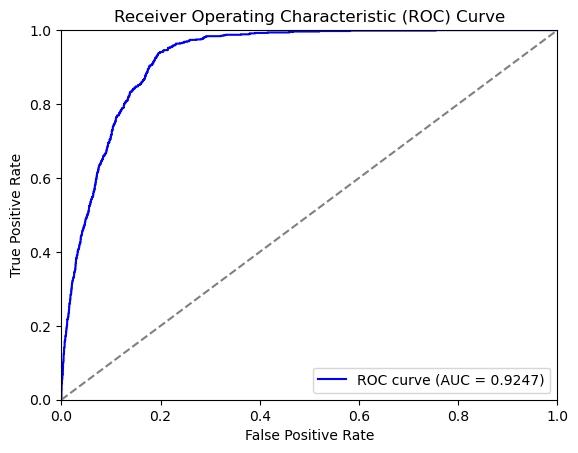

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

#calculating probabilities for each class separately
y_proba = model.predict_proba(X_test)[:, 1]

#computing ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

#computing AUC score
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc_score:.4f}")

#plotting ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


An AUC score of 0.9388 indicates good model performance. ROC curve is also pretty good and has minimal area in the top left corner which means there is a high true positive rate.

In [36]:
#XGBoost (using SMOTE, undersampling and SKF)

import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier


X = excel_df.drop(columns=['y']) #Dropping all columns except for y
y = excel_df['y'] 

categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
#Performing label encoding on the categorical variables
for column in categorical_columns:
    X[column] = le.fit_transform(X[column])

#Label encoding the target variable separately
y = le.fit_transform(y)

#Train-test split, 80 - 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Combining SMOTE with undersampling
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)
my_model = XGBClassifier()
my_model.fit(X_resampled, y_resampled, verbose=False)

predictions = my_model.predict(X_test)
#stratified K fold validation to boost accuracy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_resampled, y_resampled, cv=skf, scoring='f1_macro')

print(f"Cross-validated F1 scores: {scores}")
print(f"Mean F1 score: {scores.mean():.4f}")

model.fit(X_resampled, y_resampled)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))


Cross-validated F1 scores: [0.87449355 0.87280447 0.86641158 0.87481659 0.88490883]
Mean F1 score: 0.8747
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      5304
           1       0.48      0.83      0.61       794

    accuracy                           0.86      6098
   macro avg       0.73      0.85      0.76      6098
weighted avg       0.91      0.86      0.88      6098



This model achieved a solid mean cross-validated F1 score of 0.8747 and an overall accuracy of 86%, showing strong performance in predicting the majority class. However, while recall for the minority class (class 1) is high (0.83), precision remains low (0.48), indicating a tendency to predict false positives. The macro-average F1 score of 0.76 suggests room for improvement in handling class imbalance, despite good overall performance.